In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

In [178]:
# Global settings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', None)

### === 01. Data Pre-processing ===

#### Load the survey result downloaded from [google form](https://docs.google.com/spreadsheets/d/144Tx3auPXrIipt8SbcE4BcGVDxhsc9SV-e1HVpsrajA/edit?resourcekey#gid=1236721385)

In [46]:
file_path = './survey_res_example.csv'
survey_res = pd.read_csv(file_path)

In [47]:
# Number of respondents
len(survey_res)

28

#### Rename survey questions

In [48]:
survey_res.columns.tolist()

['Timestamp',
 'Have you engaged in data-related work (such as data analysis, data engineering, or data science) as part of your job?',
 'When do you typically search for datasets? (select all that apply)',
 'Where do you typically look for datasets? (select all that apply)',
 'Could you specify and describe the tools you use for data searching?',
 'How do you usually find the correct dataset for your needs? (select all that apply)',
 'Please briefly describe your approach when using the methods selected for finding datasets. For instance, if you chose "Consultation with coworkers or experts", what would you ask for?',
 'What content-related metadata do you find useful in locating relevant datasets? (select all that apply)',
 'What table-related metadata do you find useful in locating relevant datasets? (select all that apply)',
 'Imagine you had an ideal dataset search system, can you give an example query (the query can be in natural language, doesn’t have to be SQL) that you would l

In [49]:
# Creating a dictionary for renaming columns
rename_dict = {
    'Have you engaged in data-related work (such as data analysis, data engineering, or data science) as part of your job?': 'is_data_worker',
    'When do you typically search for datasets? (select all that apply)': 'search_purpose',
    'Where do you typically look for datasets? (select all that apply)': 'search_location',
    'Could you specify and describe the tools you use for data searching?': 'search_tool',
    'How do you usually find the correct dataset for your needs? (select all that apply)': 'data_discover_methods',
    'Please briefly describe your approach when using the methods selected for finding datasets. For instance, if you chose "Consultation with coworkers or experts", what would you ask for?': 'data_discover_methods_text',
    'What content-related metadata do you find useful in locating relevant datasets? (select all that apply)': 'content_metadata',
    'What table-related metadata do you find useful in locating relevant datasets? (select all that apply)': 'table_metadata',
    'Imagine you had an ideal dataset search system, can you give an example query (the query can be in natural language, doesn’t have to be SQL) that you would like to find relevant datasets for?': 'ideal_query_example',
    'What challenges do you face in finding relevant datasets? (select all that apply)': 'data_discover_challenges',
    "Could you provide a specific example about the challenges you've selected above?": 'data_discover_challenges_text',
    'What is your current position?': 'position',
    'How many years of experience do you have working with data?': 'year_of_experience',
    'Please specify your industry or the organization you work for.': 'industry',
    'If you are interested in participating in further studies, please leave your name and email. (Your personal information will be kept confidential and used solely for research purposes.)': 'participation_willingness'
}

# Renaming the columns
survey_res.rename(columns=rename_dict, inplace=True)

survey_res.columns.tolist()

['Timestamp',
 'is_data_worker',
 'search_purpose',
 'search_location',
 'search_tool',
 'data_discover_methods',
 'data_discover_methods_text',
 'content_metadata',
 'table_metadata',
 'ideal_query_example',
 'data_discover_challenges',
 'data_discover_challenges_text',
 'position',
 'year_of_experience',
 'industry',
 'participation_willingness']

#### Filter responses from those who indicated "Yes" to engaging in data-related work

In [50]:
survey_res = survey_res[survey_res['is_data_worker'] == 'Yes']

len(survey_res)

28

#### Filter responses from researchers who are not our system's target user

In [52]:
survey_res_non_researcher = survey_res[(survey_res['position'] != 'Researcher') & (~survey_res['position'].str.contains('professor', case=False))]

len(survey_res_non_researcher)

19

### === 02. Functions Handling Different Types of Questions Analysis ===

#### Helper functions
- ***Single choice barchart plot***

In [156]:
# Visualize the distribution of SINGLE-choice questions
def plot_single_choice_distribution(data, column_name, title, palette='cubehelix'):
    # Get the distribution of the column
    distribution_data = data[column_name].value_counts()
    
    # Plot the distribution in barplot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(y=distribution_data.index, x=distribution_data.values, palette=palette)
    plt.title(title)
    
    # Correct percentage calculation
    total = distribution_data.sum()
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width() + 0.02  # Shift the text to the right side of the bar
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    
    plt.xlabel('Count')
    plt.ylabel(column_name)
    plt.show()

In [157]:
# Plot distributions for multiple single-choice questions in batch
def batch_plot_single_choice(data, column_names, titles=None, palette='cubehelix'):
    if titles is None:
        titles = column_names
    
    # Ensure the titles list matches the length of the column_names list
    assert len(titles) == len(column_names)
    
    for column_name, title in zip(column_names, titles):
        plot_single_choice_distribution(data, column_name, title, palette)

- ***Multiple choice barchart plot***

In [158]:
# Plot the distribution of multi-choice question responses, handling predefined options
def plot_multi_choice_distribution(data, column_name, predefined_options, title, palette='cubehelix'):
    # Initialize a counter for the choices
    choice_counts = Counter()

    # Iterate through each response, handling predefined options
    for response in data[column_name].dropna():
        # Work with a lowercased version for case-insensitive matching
        response_lower = response.lower()

        # Check and count each predefined option
        for option in predefined_options:
            if option.lower() in response_lower:
                choice_counts[option] += 1
                # Remove the matched predefined option from the response string to prevent double-counting
                response_lower = response_lower.replace(option.lower(), '')

        # After all predefined options have been handled, split and count any remaining options
        other_options = [opt.strip() for opt in response_lower.split(',') if opt.strip()]
        for opt in other_options:
            choice_counts[f"Other: {opt}"] += 1

    # Convert counter to Series for plotting
    choice_series = pd.Series(choice_counts).sort_values(ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=choice_series.values, y=choice_series.index, palette=palette)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(column_name)

    # Adding percentage annotations
    total = len(data[column_name])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width() + 0.02  # Shift the text to the right side of the bar
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))

    plt.show()

In [165]:
# Plot distributions for multiple multi-choice questions in batch
def batch_plot_multi_choice(data, column_options_dict, titles=None, palette='cubehelix'):
    if titles is None:
        titles = list(column_options_dict.keys())
    
    # Ensure the titles list matches the length of the column_options_dict keys
    assert len(titles) == len(column_options_dict)
    
    for column_name, predefined_options in column_options_dict.items():
        # Find the title for the current column, defaulting to the column name if not provided
        title = titles[list(column_options_dict.keys()).index(column_name)]
        # Call the plot_multi_choice_distribution function for each column
        plot_multi_choice_distribution(data, column_name, predefined_options, title, palette)

- ***Short answer questions wordcloud***

In [182]:
def plot_word_cloud(data, column_name):
    # Combine all responses into one large text string
    text = " ".join(response for response in data[column_name].dropna())
    
    # Generate a set of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Create the word cloud object, setting the stopwords to the nltk stopwords
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axes
    plt.show()

### === 03. Results Visualization ===

#### Respondents' demographics

In [159]:
column_names_demo = ['position', 'year_of_experience', 'industry']
titles_demo = ['Position Distribution', 'Experience Years Distribution', 'Industry Distribution']

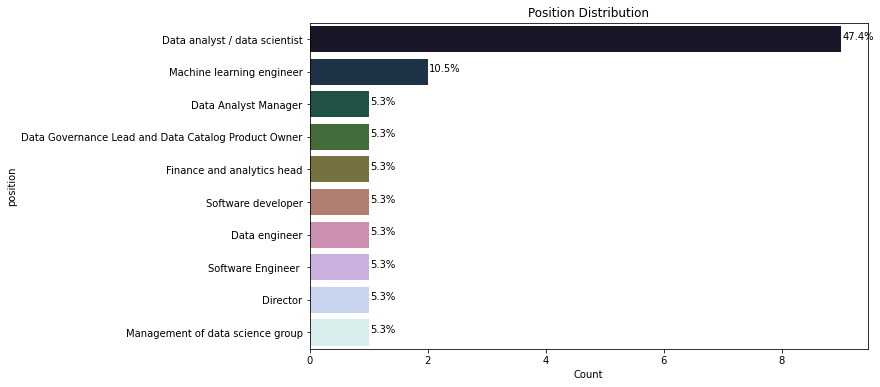

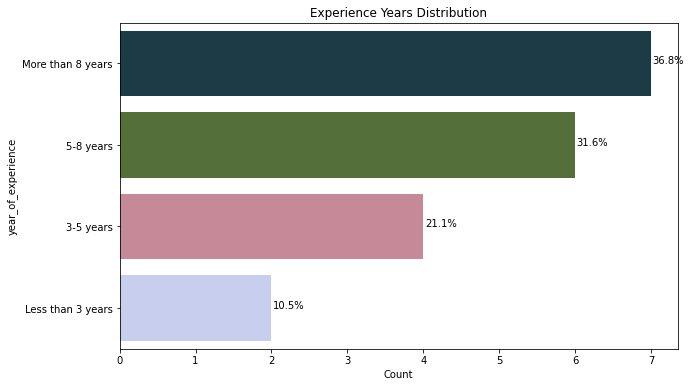

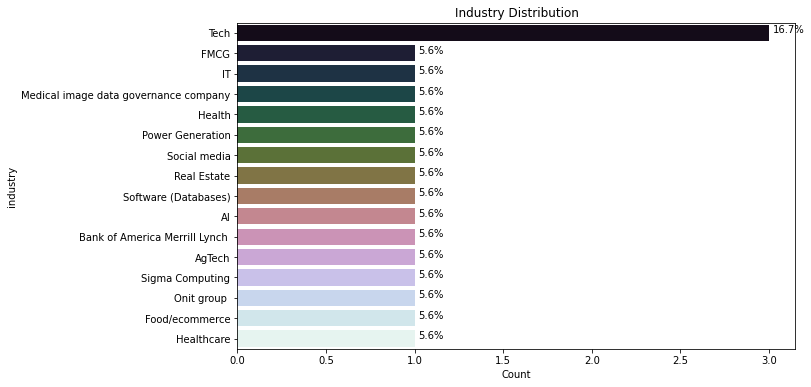

In [160]:
batch_plot_single_choice(survey_res_non_researcher, column_names_demo, titles_demo)

#### Current dataset search practices & challenges

> **When** do you typically search for datasets?

> **Where** do you typically look for datasets?

In [167]:
column_options_dict = {
    'search_purpose': [
        'To find the right dataset for the analysis', 
        'To augment an already identified specific dataset'
    ],
    'search_location': [
        'Internal data management systems within my organization', 
        'External sources (e.g., open data portals, public databases)'    
    ]
}

titles = ['When do you typically search for datasets?', 'Where do you typically look for datasets?']

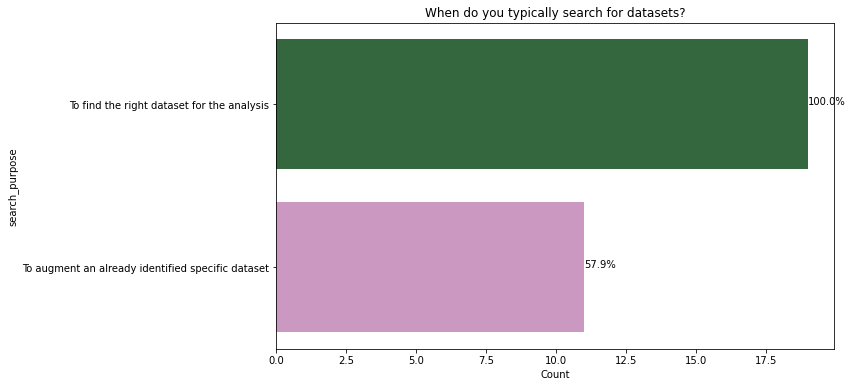

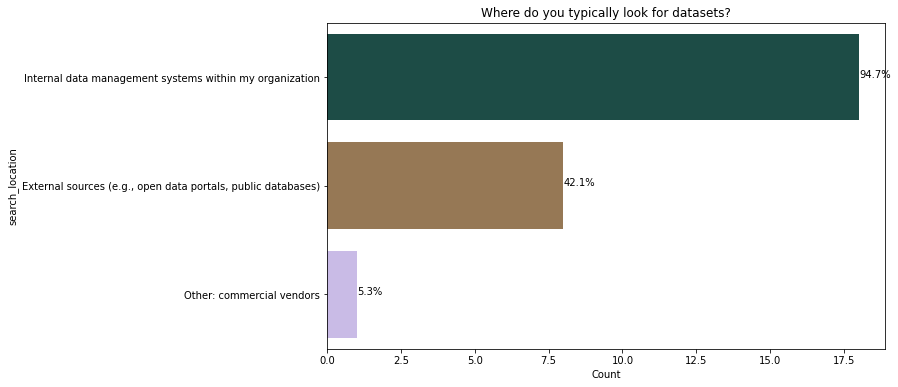

In [168]:
batch_plot_multi_choice(survey_res_non_researcher, column_options_dict, titles)

> Could you specify and describe the **tools you use** for data searching?

In [177]:
pd.DataFrame(survey_res_non_researcher['search_tool'])

,search_tool
0,internal database repositories
1,hive database
2,mysql，powerBI，Google
3,talking with stakeholders and DE; data catelog
4,"Google, NCBI, MedPix, IDA-USC"
5,"Sql, scuba, hive"
6,Internal code repositories or contractor database sites
7,"Websites like Kaggle, data scrapping with Selenium"
9,internal workplace search
10,Alation


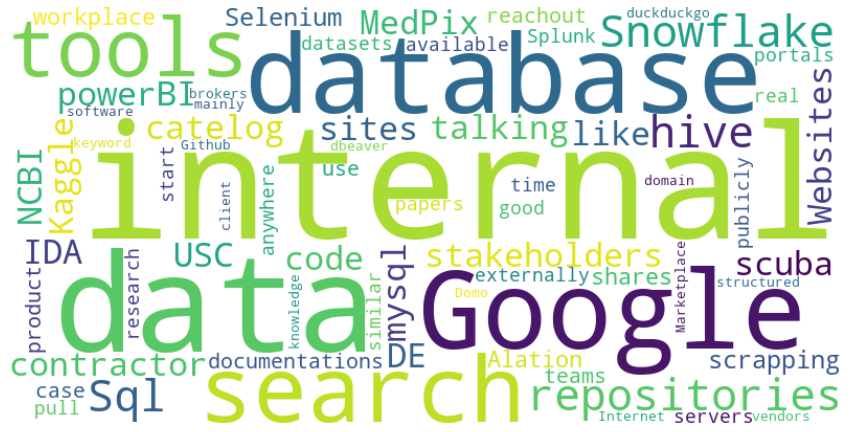

In [181]:
plot_word_cloud(survey_res_non_researcher, 'search_tool')

> **How** do you usually find the correct dataset for your needs?

In [183]:
column_options_dict = {
    'data_discover_methods': [
        'Using specific search queries or keywords', 
        'Browsing through categories or tags',
        'Utilizing advanced search filters (e.g., date range, data type)',
        'Relying on recommendations or ratings from other users',
        'Consultation with coworkers or experts',
        'Automated suggestions based on previous searches or usage',
        'Finding datasets for merge (union) or join with a specific existing table'
    ]
}

titles = ['How do you usually find the correct dataset for your needs?']

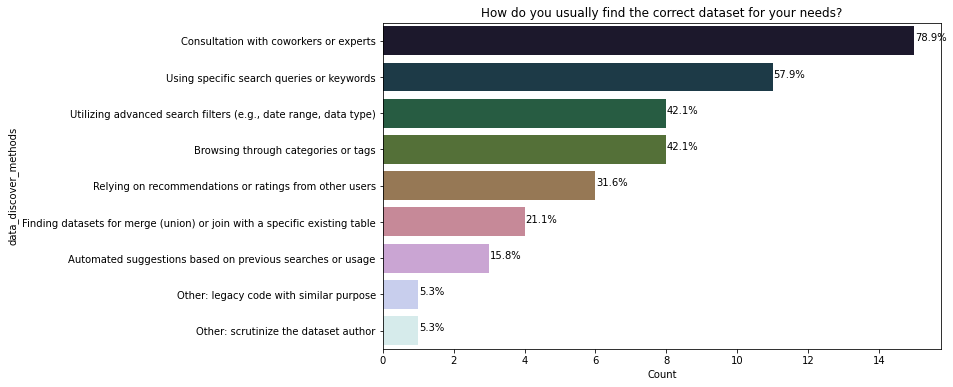

In [184]:
batch_plot_multi_choice(survey_res_non_researcher, column_options_dict, titles)

> Please briefly **describe your approach** when using the methods selected for finding datasets. For instance, if you chose "Consultation with coworkers or experts", what would you ask for?

In [185]:
pd.DataFrame(survey_res_non_researcher['data_discover_methods_text'])

,data_discover_methods_text
0,"Most of the time, I'll provide contexts to data engineer partners to help clarify where and how to find data needed for specific questions"
1,Search with naming conventions and verify it with data engineers
2,"1. to understand the data scope and definition;2. Get access to a sample set and run some analysis test; 3. If no problem need to find we to integrate data into analysis, if not find another data."
3,NaN
4,Use “like” command in sql
5,Search in company’s internal database and Q&A groups
6,I want to know which dataset will help me get to the correct answer or give me the best data to answer my question
7,Use the specific search query keyword and add dataset to it.
9,Ask about the key outputs i was looking for
10,Navigating the data catalog and confirming with data source admins/custodians for verification


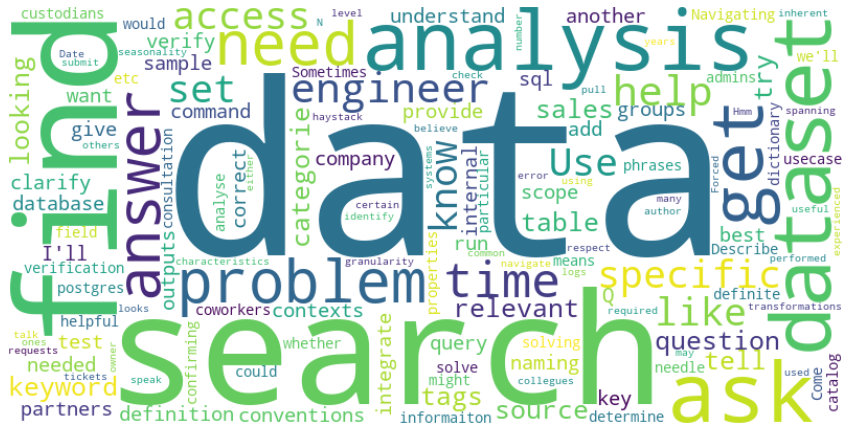

In [186]:
plot_word_cloud(survey_res_non_researcher, 'data_discover_methods_text')

> What **content-related metadata** do you find useful in locating relevant datasets?

> What **table-related metadata** do you find useful in locating relevant datasets?

In [189]:
column_options_dict = {
    'content_metadata': [
        'Data types contained within the dataset',
        'Presence and extent of missing values (percentage/number of missing entries)',
        'Descriptive information (e.g., table/column name, table description, tags)',
        'Statistical summaries of specific columns (e.g., average, distinct, distribution)',
        'Granularity of specific columns (e.g., geographic or temporal detail)',
        'Level of detail in the dataset (e.g., item level vs. category level in product tables)',
        'Granularity of specific columns (e.g., product level, geographic or temporal detail)' # This is the updated option combining the above two options
    ],
    'table_metadata': [
        'Previous SQL queries made by other users on the dataset',
        'Usage data (e.g., number of accesses, frequency of use)',
        'Update history (e.g., frequency and schedule of data updates)',
        'Availability of earliest data in the dataset',
        'Detailed schema of the dataset',
        'Dimension details (e.g., number of columns, size of dataset)',
        'Data lineage'    
    ]
}

titles = ['What content-related metadata do you find useful in locating relevant datasets?', 'What table-related metadata do you find useful in locating relevant datasets?']

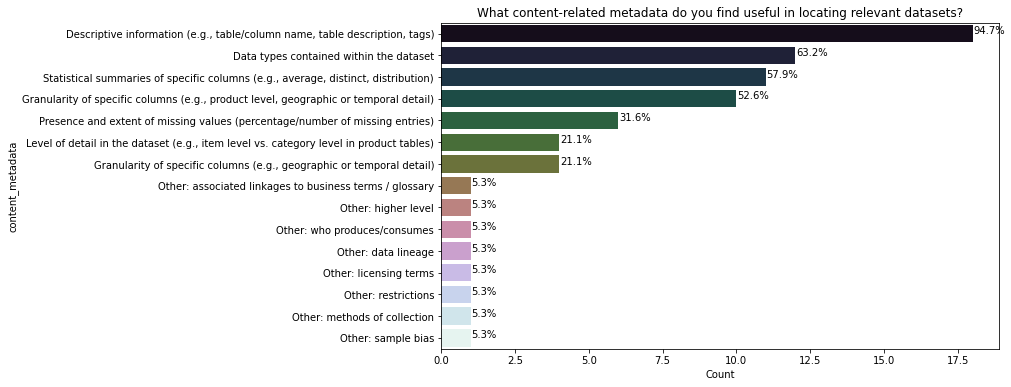

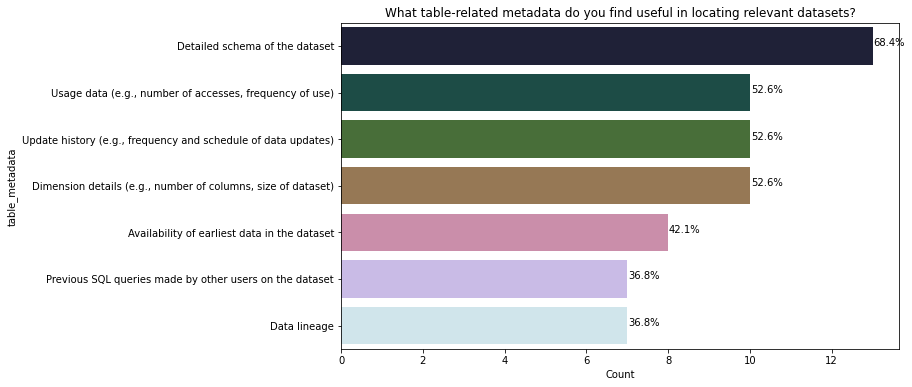

In [190]:
batch_plot_multi_choice(survey_res_non_researcher, column_options_dict, titles)

> Imagine you had an ideal dataset search system, can you give an **example query** (the query can be in natural language, doesn’t have to be SQL) that you would like to find relevant datasets for?

In [192]:
pd.DataFrame(survey_res_non_researcher['ideal_query_example'])

,ideal_query_example
0,which table/ column can I use to query user level purchasing data?
1,Keywords of the subjects+ username of previous users
2,Help me locate the data relate to sales in database
3,help me find the data with XXXX information and relevant columns.
4,Find “target”;
5,N/a
6,Give me the inventory dataset with the most up to date categories within this date range
7,Cardiograph data set taken in the last 5 years.
9,Help me find the dataset for xxx information
10,"CONTAINS LIKE ""&SCHEMA.TABLE"" or select all tables that contains words ""%XXX%"""


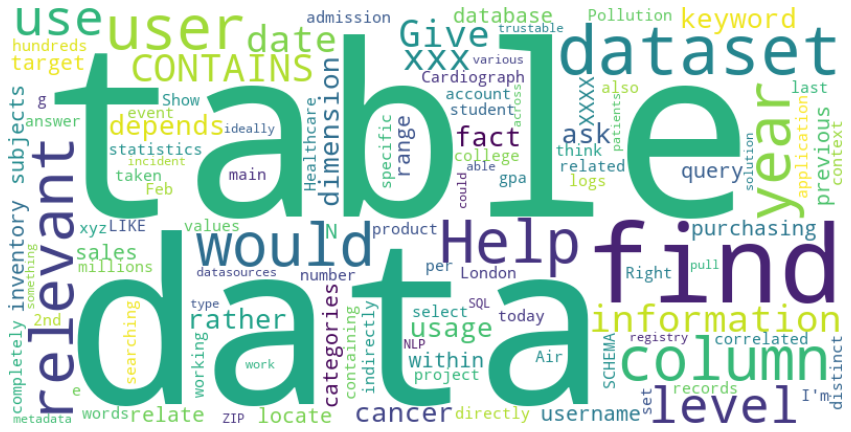

In [193]:
plot_word_cloud(survey_res_non_researcher, 'ideal_query_example')

> What **challenges** do you face in finding relevant datasets?

In [194]:
column_options_dict = {
    'data_discover_challenges': [
        'Excessive retrieval of similar datasets',
        'Joinability issues (finding datasets that can be joined)',
        "Column values with unclear meanings (e.g., 'color' column with values 1, 2, 3 representing 'red', 'yellow', 'green')",
        'Presence of too many irrelevant data attributes',
        'Confusion about the level of detail in tables (e.g., item level vs. category level data)',
        'Inconsistent naming conventions across different datasets',
        'Limited expressiveness in search functionality',
        'Translating project objectives (e.g., specific analyses / ML models) into effective data search query'
    ]
}

titles = ['What challenges do you face in finding relevant datasets?']

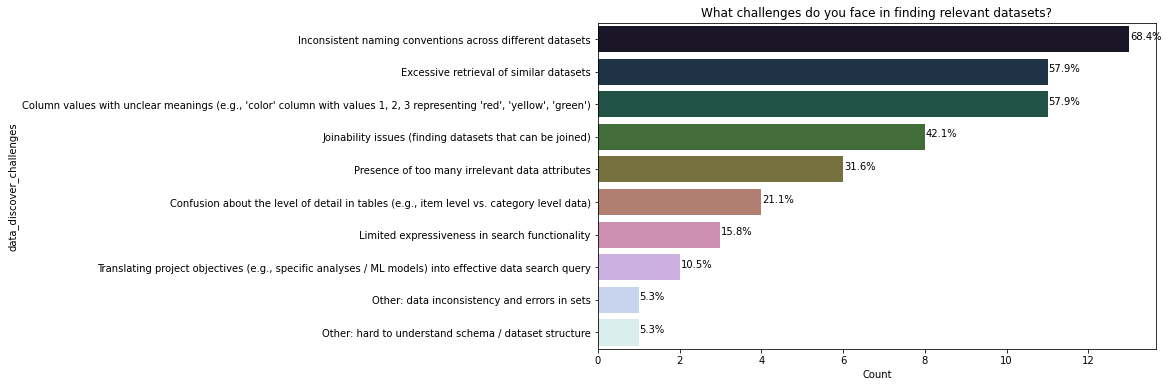

In [195]:
batch_plot_multi_choice(survey_res_non_researcher, column_options_dict, titles)

> Could you provide **a specific example** about the **challenges** you've selected above?

In [196]:
pd.DataFrame(survey_res_non_researcher['data_discover_challenges_text'])

,data_discover_challenges_text
0,"Most of the time there are too many table results after the initial search. Some of the filed definitions are slightly different (for example, when refers to age information, age bucket might be different)."
1,No name description for data columns
2,"In product table, we have different product hierarchy, so some product belongs to A category in table A, but belongs to category B in table B"
3,"same fields may have different names in two tables, and sometimes the same name may means different in two tables."
4,Hospital names across databases are different and ending up with “human” matching outsourced to India to join them.
5,Datasets don’t have joint key
6,Many data tables have very similar names or not human readable names
7,"data duplication, not able to tell if the returned results were already returned"
9,Same information can be stored in various datasets for different purposes
10,"Incorrect classification and tagging, multiple datasets that are same structure but different refresh, dont exist in catalog, ref integrity in joining"


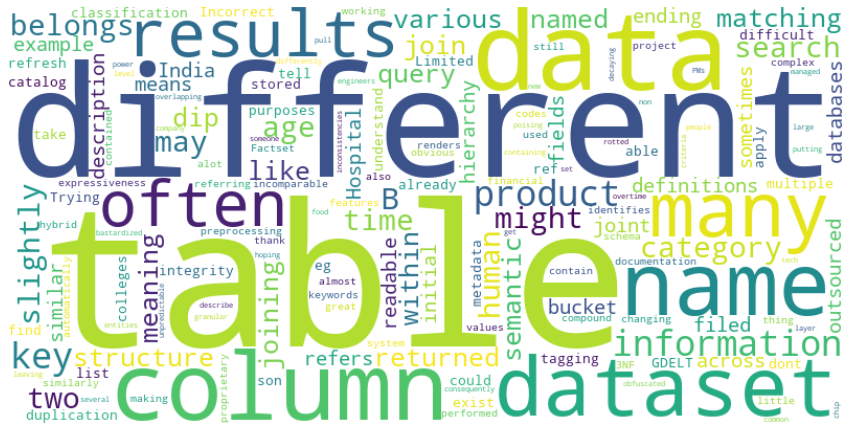

In [197]:
plot_word_cloud(survey_res_non_researcher, 'data_discover_challenges_text')